# Importing dependencies

In [1]:
import os
import glob
import time
import datetime

import numpy as np
import pandas as pd
import xarray as xr
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib

# Hyperparameters for training

In [2]:
# data param
day_len = 30
batch_size = 16

# model param
num_filters = 16

# training param
epochs = 100
learning_rate = 0.001

# Loading the data

In [3]:
# load data 
data_models = ['GFDL-ESM4','IPSL-CM6A-LR','MPI-ESM1-2-HR']  # models for temp, prec, LAI
dmodel = 'IPSL-CM6A-LR' # np.random.choice(np.array(data_models))  # TODO: choose a model

temp_ds = np.array(xr.open_mfdataset('data/near_surface_air_temperature/historical/{}/*.nc'.format(dmodel)).tas)
prec_ds = np.array(xr.open_mfdataset('data/precipitation_flux/historical/{}/*.nc'.format(dmodel)).pr)

npp_files = glob.glob('data/net_primary_production_on_land/historical/**/*.nc', recursive=True) # TODO: use all models
npp_ds = np.array(xr.open_mfdataset(np.random.choice(np.array(npp_files))).npp)
npp_ds = np.nan_to_num(npp_ds)
lai_dx = xr.open_mfdataset('data/leaf_area_index/historical/{}/*.nc'.format(dmodel))  # not numpy as time index needed
lai_dx['lai'] = lai_dx.lai.fillna(0)

# Normalizing the outputs (LAI and NPP)

In [4]:
# min-max scale outputs to [0,10]
max_output = 10
npp_ds_s = max_output* (npp_ds-np.min(npp_ds))/(np.max(npp_ds)-np.min(npp_ds))
lai_ds_o = lai_dx['lai'] 
lai_dx["lai"] = max_output * (lai_dx.lai - np.min(lai_dx.lai))/(np.max(lai_dx.lai)-np.min(lai_dx.lai))

# Train and Validation Split

In [5]:
train_max_month = 1978-(12*14)
train_min_month = day_len//28

val_max_month = 1978
val_min_month = (day_len//28) + (1978-(12*14))




# min-max scale inputs normalized only on train data (statistics will also be used to normalize test set)

train_max_index = temp_ds.shape[0] - (365*14)

# Normalizing the Inputs

In [6]:
min_temp = np.min(temp_ds)#[:train_max_index])
max_temp = np.max(temp_ds)#[:train_max_index])

min_prec = np.min(prec_ds)#[:train_max_index])
max_prec = np.max(prec_ds)#[:train_max_index])

min_input= -1
max_input = 1

temp_ds_s = (temp_ds - min_temp) * (max_input - min_input) / (max_temp - min_temp)
                                  
prec_ds_s = (prec_ds - min_prec) * (max_input - min_input) / (max_prec - min_prec)

# Tensorflow input pipeline

In [7]:
# range of output month indicies needed for plotting and generator
val_months = 12*14 # 14 years of evaluation data

train_max_month = 1978-val_months
min_month = day_len//28

val_max_month = 1978
val_min_month = train_max_month +1

def train_gen_data_card():
    while True:
        # array to append to
        endstamp = []
        output_day_i = np.zeros(batch_size)
        
        lai = np.zeros((batch_size, npp_ds.shape[1], npp_ds.shape[2]))  # batch, lon, lat
        npp = np.zeros((batch_size, npp_ds.shape[1], npp_ds.shape[2]))
        temp = np.zeros((batch_size, day_len, npp_ds.shape[1], npp_ds.shape[2]))  # batch, time, lon, lat
        prec = np.zeros((batch_size, day_len, npp_ds.shape[1], npp_ds.shape[2]))
        
        # index of output in month
        output_month_i = np.random.randint(train_min_month, train_max_month, size=batch_size)  # y_pred timepoint in int

        # convert output index to timestamp
        try:
            for i in range(batch_size):
                endstamp.append(lai_dx.indexes['time'].to_datetimeindex()[output_month_i[i]])  # cfttimeindex to datetime               
        except:
            for i in range(batch_size):
                endstamp.append(lai_dx.indexes['time'][output_month_i[i]])

        # convert output month index to day index
        for i in range(batch_size):
            output_day_i[i] = (endstamp[i] - pd.Timestamp('1850-01-01T12')).days  # output is i-th day in int
        output_day_i = np.int_(output_day_i)

        # save month-based time slices
        lainp = np.array(lai_dx.lai)
        for i in range(batch_size):
            lai[i] = lainp[output_month_i[i]]
        for i in range(batch_size):
            npp[i] = npp_ds_s[output_month_i[i]]

        # day-based metrics
        for i in range(batch_size):
            temp[i] = temp_ds_s[output_day_i[i]-day_len:output_day_i[i]]
        for i in range(batch_size):
            prec[i] = prec_ds_s[output_day_i[i]-day_len:output_day_i[i]]

        # merge features
        inputs = np.stack((temp,prec), axis=-1)  # two features
        outputs = np.stack((lai,npp), axis=-1)

        yield (inputs, outputs)
        
def val_gen_data_card():
    while True:
        # array to append to
        endstamp = []
        output_day_i = np.zeros(batch_size)
        
        lai = np.zeros((batch_size, npp_ds.shape[1], npp_ds.shape[2]))  # batch, lon, lat
        npp = np.zeros((batch_size, npp_ds.shape[1], npp_ds.shape[2]))
        temp = np.zeros((batch_size, day_len, npp_ds.shape[1], npp_ds.shape[2]))  # batch, time, lon, lat
        prec = np.zeros((batch_size, day_len, npp_ds.shape[1], npp_ds.shape[2]))
        
        # index of output in month
        output_month_i = np.random.randint(val_min_month, val_max_month, size=batch_size)  # y_pred timepoint in int

        # convert output index to timestamp
        try:
            for i in range(batch_size):
                endstamp.append(lai_dx.indexes['time'].to_datetimeindex()[output_month_i[i]])  # cfttimeindex to datetime               
        except:
            for i in range(batch_size):
                endstamp.append(lai_dx.indexes['time'][output_month_i[i]])

        # convert output month index to day index
        for i in range(batch_size):
            output_day_i[i] = (endstamp[i] - pd.Timestamp('1850-01-01T12')).days  # output is i-th day in int
        output_day_i = np.int_(output_day_i)

        # save month-based time slices
        lainp = np.array(lai_dx.lai)
        for i in range(batch_size):
            lai[i] = lainp[output_month_i[i]]
        for i in range(batch_size):
            npp[i] = npp_ds_s[output_month_i[i]]

        # day-based metrics
        for i in range(batch_size):
            temp[i] = temp_ds_s[output_day_i[i]-day_len:output_day_i[i]]
        for i in range(batch_size):
            prec[i] = prec_ds_s[output_day_i[i]-day_len:output_day_i[i]]

        # merge features
        inputs = np.stack((temp,prec), axis=-1)  # two features
        outputs = np.stack((lai,npp), axis=-1)

        yield (inputs, outputs)

In [10]:
train_ds = tf.data.Dataset.from_generator(train_gen_data_card, output_types = (tf.float32,tf.float32))
train_ds = train_ds.take(30).prefetch(tf.data.experimental.AUTOTUNE)


val_ds = tf.data.Dataset.from_generator(val_gen_data_card, output_types = (tf.float32,tf.float32))
val_ds = val_ds.take(30).prefetch(tf.data.experimental.AUTOTUNE)

InternalError: CUDA runtime implicit initialization on GPU:0 failed. Status: out of memory

# Defining the Convolutional LSTM-Net

In [ ]:
class ConvLSTM(tf.keras.Model):
    def __init__(self, num_filters):
        super(ConvLSTM, self).__init__()
        
        do = 0.2
        self.convlstm2D_1 = tf.keras.layers.ConvLSTM2D(filters = num_filters, kernel_size=(3,3),
                                                     padding="same", return_sequences=True,
                                                      activation = "tanh")
        self.bn_1 = tf.keras.layers.BatchNormalization()
        
        self.convlstm2D_2 = tf.keras.layers.ConvLSTM2D(filters = num_filters, kernel_size=(3,3),
                                                     padding="same", return_sequences=True,
                                                      activation = "tanh")
        self.bn_2 = tf.keras.layers.BatchNormalization()


        self.convlstm2D_3 = tf.keras.layers.ConvLSTM2D(filters = num_filters, kernel_size=(3,3),
                                                     padding="same", return_sequences=True,
                                                      activation = "tanh")
        self.bn_3 = tf.keras.layers.BatchNormalization()
        
        self.convlstm2D_4 = tf.keras.layers.ConvLSTM2D(filters = num_filters, kernel_size=(3,3),
                                                     padding="same", return_sequences=True,
                                                      activation = "tanh")
        self.bn_4 = tf.keras.layers.BatchNormalization()
        
        # convolve over time, lat, lon. This means that we assume timesteps close to each other share local similarities
        self.conv3d = tf.keras.layers.Conv3D(filters = 2, kernel_size = (3,3,3), 
                                             activation= "tanh", padding="same")
        
        self.do3d = tf.keras.layers.Dropout(do)
        # computed convolved sum over all time dimension to get a single time slice
        self.bottleneck = tf.keras.layers.Conv3D(filters=1, kernel_size=1, activation="relu",strides=1)


    def call(self, x, training, input_shape):
        # (batch, time, lat, lon, channel)
        x = tf.ensure_shape(x, input_shape) 
        # (batch, time, lat, lon, channel)
        x = self.convlstm2D_1(x,training= training)
        # (batch, time, lat1, lon1, filter1)
        x = self.bn_1(x,training = training)
        
        x = self.convlstm2D_2(x,training = training)
        x = self.bn_2(x,training = training)
        
        x = self.convlstm2D_3(x,training = training)
        x = self.bn_3(x,training = training)
        
        x = self.convlstm2D_4(x,training = training)
        x = self.bn_4(x, training = training)
        # (batch, time, lat4, lon4, filter4)
        x = self.do3d(x,training= training)
        x = self.conv3d(x)
        # (batch, newtime, newlat, newlon, newfilter=2)
        
        x = tf.transpose(x, [0,4,2,3,1])
        # (batch, 2, lat, lon, time)
        x = self.bottleneck(x)
        # (batch, 2, lat, lon, 1)
        
        x = tf.transpose(x, [0,4,2,3,1])
        # (batch, 1, lat, lon, 2)
        x = tf.squeeze(x,axis=1)
        # (batch, lat, lon, 2)
        
        return x

# Defining a custom train and evaluation step

In [ ]:
@tf.function
def train_step(model, data, loss_function, optimizer, train_loss_metric, input_shape=input_shape):
    '''
    Training for one epoch.
    '''
    for img, target in train_ds:
        # forward pass with GradientTape
        with tf.GradientTape() as tape:
            prediction = model(img, training=True, input_shape=input_shape)
            loss = loss_function(target, prediction) + tf.reduce_sum(model.losses)

        # backward pass via GradienTape (auto-gradient calc)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        # update metrics
        train_loss_metric.update_state(loss)
        
#@tf.function        
def eval_step(model, ds, loss_function, loss_metric, input_shape=input_shape):
    '''
    Evaluation Loop.
    '''
    for sequence, target in ds:
        # forward pass
        prediction = model(sequence, training=False, input_shape=input_shape)
        # update metrics
        loss = loss_function(target, prediction)
        loss_metric.update_state(loss)
        
    fig, axe = plt.subplots(2,3, figsize=(25,10))
    plt.tight_layout(pad= 0.05)
    axe[0,0].imshow(target[0,:,:,0], cmap='gray', origin='lower')
    axe[0,1].imshow(prediction[0,:,:,0], cmap='gray', origin='lower')
    axe[1,0].imshow(target[0,:,:,1], cmap='gray', origin='lower')
    axe[1,1].imshow(prediction[0,:,:,1], cmap='gray', origin='lower')
    axe[0,2].imshow(np.abs(target[0,:,:,0]-prediction[0,:,:,0]), cmap = "bwr", 
                    origin= "lower", vmin = 0,vmax =max_output)
    axe[1,2].imshow(np.abs(target[0,:,:,1]-prediction[0,:,:,1]), cmap = "bwr", 
                    origin= "lower", vmin = 0,vmax =max_output)

# Instantiate Model, Loss and Optimizer

In [ ]:
model = ConvLSTM(num_filters=num_filters)
input_shape = (batch_size, day_len, 36, 72, 2)

# define loss
loss_function = tf.keras.losses.MSE
# define optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Defining a timer class

In [ ]:
class Timer():
    """
    A small class to measure time during training.
    """
    def __init__(self):
        self._start_time = None

    def start(self):
        """
        Start a new timer
        """
        self._start_time = time.perf_counter()

    def stop(self):
        """
        Stop the timer, and report the elapsed time
        """
        if self._start_time is None:
            print(f"Timer is not running. Use .start() to start it")
            return 0
    
        elapsed_time = time.perf_counter() - self._start_time
        self._start_time = None
        
        return elapsed_time

# Instantiating Tensorboard metrics

In [ ]:
timer = Timer()

# 2nd-order metric to take mean over all samples
train_loss_metric = tf.keras.metrics.Mean('train_loss')
val_loss_metric = tf.keras.metrics.Mean('val_loss')

# initialize the logger for Tensorboard visualization
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/' + current_time + '/train_ConvLSTM'    
val_log_dir = 'logs/gradient_tape/' + current_time + '/val_ConvLSTM'       
train_summary_writer = tf.summary.create_file_writer(train_log_dir)  
val_summary_writer = tf.summary.create_file_writer(val_log_dir)

times = []

# Iterating over the epochs (finally training the model)

In [ ]:
for epoch in range(epochs):
    print(f'\n[EPOCH] ____________________{epoch}____________________')
    
    # training step with metrics update--------------------------------------------------------
    timer.start()
    
    train_step(model, train_ds, loss_function, optimizer, train_loss_metric)
    train_loss = train_loss_metric.result()
    
    with train_summary_writer.as_default():     # logging our metrics to a file which is used by tensorboard
        tf.summary.scalar('loss', train_loss, step=epoch)
    elapsed_time = timer.stop()
    print(f'[{epoch}] - Finished Epoch in {elapsed_time:0.2f} seconds - train_loss: {train_loss:0.4f}')
    
    # evaluation step with metrics update--------------------------------------------------------
    timer.start()
    eval_step(model, val_ds, loss_function, loss_metric=val_loss_metric)
    plt.show()
    
    val_loss = val_loss_metric.result()    
    with val_summary_writer.as_default():       # logging our metrics to a file which is used by tensorboard
        tf.summary.scalar('loss', val_loss, step=epoch)    
    print(f'\n[{epoch}] - Finished evaluation - val_loss: {val_loss:0.4f}')
    
    # Resetting train and validation metrics-----------------------------------------------------
    train_loss_metric.reset_states()
    val_loss_metric.reset_states()
    elapsed_time = timer.stop()
    times.append(elapsed_time)
  
    if epoch%3 == 0:
        print(f'\n[INFO] - Total time elapsed: {np.sum(times)/60:0.4f} min. Total time remaining: {(np.sum(times)/(epoch+1))*(epochs-epoch-1)/60:0.4f} min.')

print(f'[INFO] - Total run time: {np.sum(times)/60:0.4f} min.')

# Saving our model

In [ ]:
training_name = "Train_run_7"

model.save_weights("model_weights/"+ training_name + ".hdf5",save_format="hdf5",overwrite=False)

# Predicting the future of plants with our trained model

It is to note that we trained the model on the full dataset again after evaluation (including the most recent 14 years)

In [ ]:
data_models = ['GFDL-ESM4','IPSL-CM6A-LR','MPI-ESM1-2-HR']  # models for temp, prec, LAI
dmodel = 'IPSL-CM6A-LR' # np.random.choice(np.array(data_models))  
scenarios = ['ssp126', 'ssp370', 'ssp585']

scenario = scenarios[0] # 0 optimistic, 1 intermediate, 2 pessimistic

# load historical data
dx_temp = xr.open_mfdataset('data/near_surface_air_temperature/historical/{}/*.nc'.format(dmodel)).tas
dx_prec = xr.open_mfdataset('data/precipitation_flux/historical/{}/*.nc'.format(dmodel)).pr

# load prediction of climate until 2100 and concatanate with historical data
dx_temp_future = xr.open_mfdataset('data/near_surface_air_temperature/{}/{}/*.nc'.format(scenario, dmodel)).tas
dx_temp_future = xr.concat((dx_temp, dx_temp_future), dim='time')
dx_prec_future = xr.open_mfdataset('data/precipitation_flux/{}/{}/*.nc'.format(scenario, dmodel)).pr
dx_prec_future = xr.concat((dx_prec, dx_prec_future), dim='time')

# Normalizing the future's input data with past data

In [ ]:
# Preprocessing
train_max_index = dx_temp.shape[0] - (365*14)

min_temp = np.min(dx_temp)
max_temp = np.max(dx_temp)

min_prec = np.min(dx_prec)
max_prec = np.max(dx_prec)

min_input = -1
max_input = 1

dx_temp_future = (dx_temp_future - min_temp) * (max_input - min_input) / (max_temp - min_temp)
dx_prec_future = (dx_prec_future - min_prec) * (max_input - min_input) / (max_prec - min_prec)

# Tensorflow Dataset input pipeline for prediction

In [ ]:
def gen_future_climate():
#     first_month = (2015-1850)*12 + 1  # int index of which month january 2015 is with 0 being january 1850

    counter = 0
    while counter < total_months: # predict from 2015 to 2100, excluding last month
        cyear = (counter//12) + 2015
        
        cmonth = (counter+1) % 12
        
        if cmonth == 0:
            cmonth = 12
        
        current_timestamp = pd.Timestamp(cyear, cmonth, 1)
        input_start_timestamp = current_timestamp - pd.Timedelta(day_len-1, unit='day')

        counter += 1
       
        data = np.stack((np.array(dx_temp_future.loc[input_start_timestamp:current_timestamp+pd.Timedelta(1,unit='day')]),
                         np.array(dx_prec_future.loc[input_start_timestamp:current_timestamp+pd.Timedelta(1,unit='day')])),
                         axis=-1)
        
        yield data

In [ ]:
# data pipeline
ds_future = tf.data.Dataset.from_generator(generator=gen_future_climate, 
                                           output_types=(tf.float32)).batch(batch_size)

In [ ]:
model = ConvLSTM(num_filters=num_filters)
input_shape = (batch_size, day_len, 36, 72, 2)

# load weights of trained model

In [ ]:
def load_weights(model, weight_file, dataset, input_shape):
    """
    Builds the model by using the call method on input and then loads the weights.
    """
    for data in dataset.take(1):
        model(data, training=False, input_shape=input_shape)
    
    model.load_weights(weight_file)

In [ ]:
load_weights(model, f'model_weights/{weight_file}.hdf5', ds_future, input_shape)

# Predicting 2015-2100 under the previously specified scenario

In [ ]:
counter = 0
for data in ds_future:
    
    try:
        predictions = np.concatenate((predictions, model(data, training=False, input_shape=input_shape)), axis=0)    
    except Exception as e:
        predictions = model(data, training=False, input_shape=input_shape)
    
    print(f'[INFO] - {counter/int(total_months/batch_size)*100:.2f}% finished')
    counter += 1

print('[INFO] - Done')

np.save('results/pred_{}'.format(weight_file), predictions)

# Plot results

In [4]:
plt.rcParams["animation.html"] = "jshtml"  # allow animation for jupyter
plt.rcParams['xtick.bottom'] = False
plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.labelleft'] = False
plt.rcParams.update({'font.size': 30})

In [30]:
# load predictions
pred_p = np.load('results/pred_Dropout_historic_Pessimistic.npy')
pred_m = np.load('results/pred_Dropout_historic_Medium.npy')
pred_o = np.load('results/pred_Dropout_historic_Optimistic.npy')

### Animation of LAI, NPP prediction

KeyboardInterrupt: 

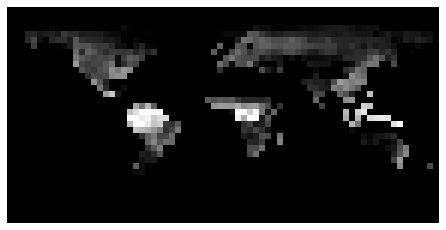

In [31]:
frames = []  # append each image
fig = plt.figure()
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)

for timeindex in range(total_months):  # animate for 1 yr

    frames.append([plt.imshow(pred_p[timeindex,:,:,0],  # change 0 to 1 for NPP
                              cmap='gray', origin='lower', animated=True)])

ani = matplotlib.animation.ArtistAnimation(fig, frames, interval=200, blit=True, repeat=False)
# ani.save('figs/pred_drop_Pessimistic_LAI.gif', writer='imagemagick', fps=10)
ani

### Plot general tendency by averaging over location

In [10]:
# load history
dn_lai = np.array(xr.open_dataset('data/leaf_area_index/historical/IPSL-CM6A-LR/lai_Lmon_IPSL-CM6A-LR_historical_r1i1p1f1_185001-201412.nc').lai)
dn_lai = np.nan_to_num(dn_lai)
min_lai = np.min(dn_lai)
max_lai = np.max(dn_lai)
dn_npp = np.array(xr.open_dataset('data/net_primary_production_on_land/historical/CMCC-CM2-SR5/npp_Lmon_CMCC-CM2-SR5_historical_r1i1p1f1_185001-201412.nc').npp)
dn_npp = np.nan_to_num(dn_npp)
min_npp = np.min(dn_npp)
max_npp = np.max(dn_npp)

# re scale pred
def redo_minmax(data, min_data, max_data, max_output):
    return ((data*(max_data-min_data))/max_output)+min_data
max_output = 10
lai_future_p = redo_minmax(pred_p[:,:,:,0], min_lai, max_lai, max_output)
npp_future_p = redo_minmax(pred_p[:,:,:,1], min_npp, max_npp, max_output)
lai_future_m = redo_minmax(pred_m[:,:,:,0], min_lai, max_lai, max_output)
npp_future_m = redo_minmax(pred_m[:,:,:,1], min_npp, max_npp, max_output)
lai_future_o = redo_minmax(pred_o[:,:,:,0], min_lai, max_lai, max_output)
npp_future_o = redo_minmax(pred_o[:,:,:,1], min_npp, max_npp, max_output)

# compute mean
lai_future_p = np.mean(lai_future_p,axis=(1,2))
npp_future_p = np.mean(npp_future_p,axis=(1,2))
lai_future_m = np.mean(lai_future_m,axis=(1,2))
npp_future_m = np.mean(npp_future_m,axis=(1,2))
lai_future_o = np.mean(lai_future_o,axis=(1,2))
npp_future_o = np.mean(npp_future_o,axis=(1,2))
dn_lai = np.mean(dn_lai,axis=(1,2))
dn_npp = np.mean(dn_npp,axis=(1,2))

# load climatic data
dn_temp = np.mean(xr.open_mfdataset('data/near_surface_air_temperature/historical/IPSL-CM6A-LR/*.nc').tas[::31], axis=(1,2))
dn_temp_p = np.mean(xr.open_mfdataset('data/near_surface_air_temperature/ssp585/IPSL-CM6A-LR/*.nc').tas[::31], axis=(1,2))
dn_temp_m = np.mean(xr.open_mfdataset('data/near_surface_air_temperature/ssp370/IPSL-CM6A-LR/*.nc').tas[::31], axis=(1,2))
dn_temp_o = np.mean(xr.open_mfdataset('data/near_surface_air_temperature/ssp126/IPSL-CM6A-LR/*.nc').tas[::31], axis=(1,2))

dn_prec = np.mean(xr.open_mfdataset('data/precipitation_flux/historical/IPSL-CM6A-LR/*.nc').pr[::31], axis=(1,2))
dn_prec_p = np.mean(xr.open_mfdataset('data/precipitation_flux/ssp585/IPSL-CM6A-LR/*.nc').pr[::31], axis=(1,2))
dn_prec_m = np.mean(xr.open_mfdataset('data/precipitation_flux/ssp370/IPSL-CM6A-LR/*.nc').pr[::31], axis=(1,2))
dn_prec_o = np.mean(xr.open_mfdataset('data/precipitation_flux/ssp126/IPSL-CM6A-LR/*.nc').pr[::31], axis=(1,2))

Show artifact

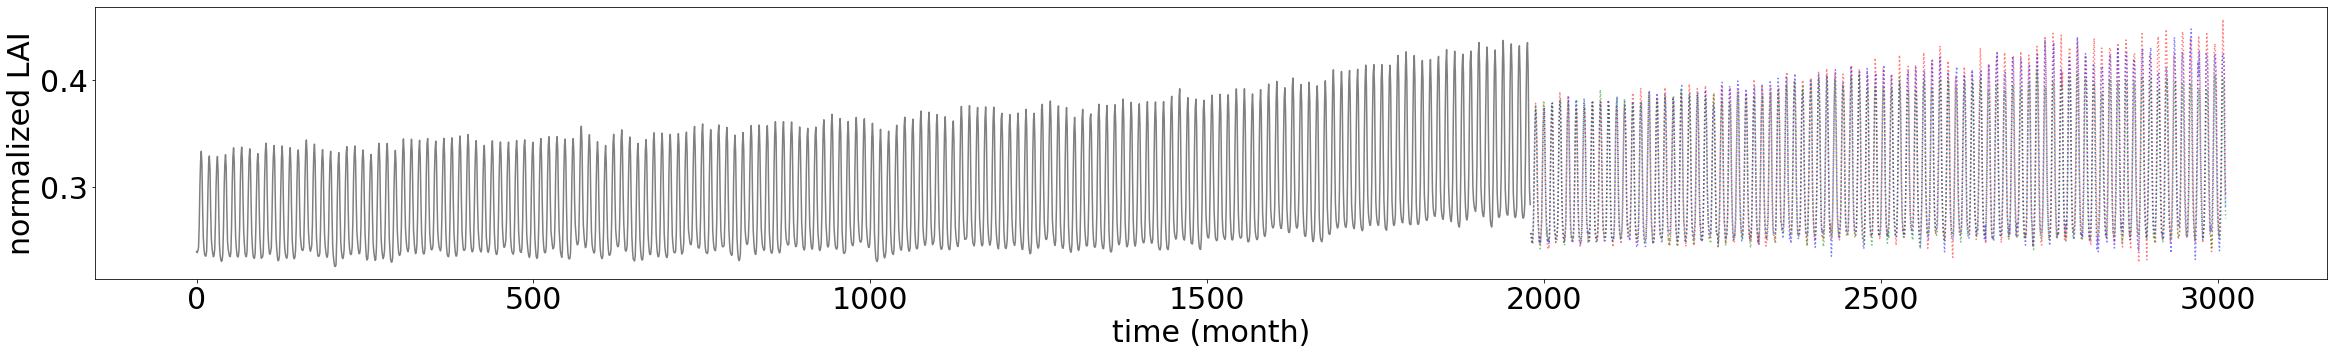

In [12]:
fig,ax = plt.subplots(figsize=(40,5))
plt.plot(np.arange(dn_lai.shape[0]),
         dn_lai,
         color='gray')
plt.plot(np.arange(dn_lai.shape[0], dn_lai.shape[0]+lai_future_p.shape[0]), 
         lai_future_p,
         color='red', linestyle='dotted', alpha=0.5)
plt.plot(np.arange(dn_lai.shape[0], dn_lai.shape[0]+lai_future_p.shape[0]), 
         lai_future_m,
         color='blue', linestyle='dotted', alpha=0.5)
plt.plot(np.arange(dn_lai.shape[0], dn_lai.shape[0]+lai_future_p.shape[0]), 
         lai_future_o,
         color='green', linestyle='dotted', alpha=0.5)
ax.set(xlabel='time (month)', ylabel='normalized LAI')

# fig.savefig('figs/artifact_scaling.png', bbox_inches='tight')

plot 4 metrics for 3 scenarios

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

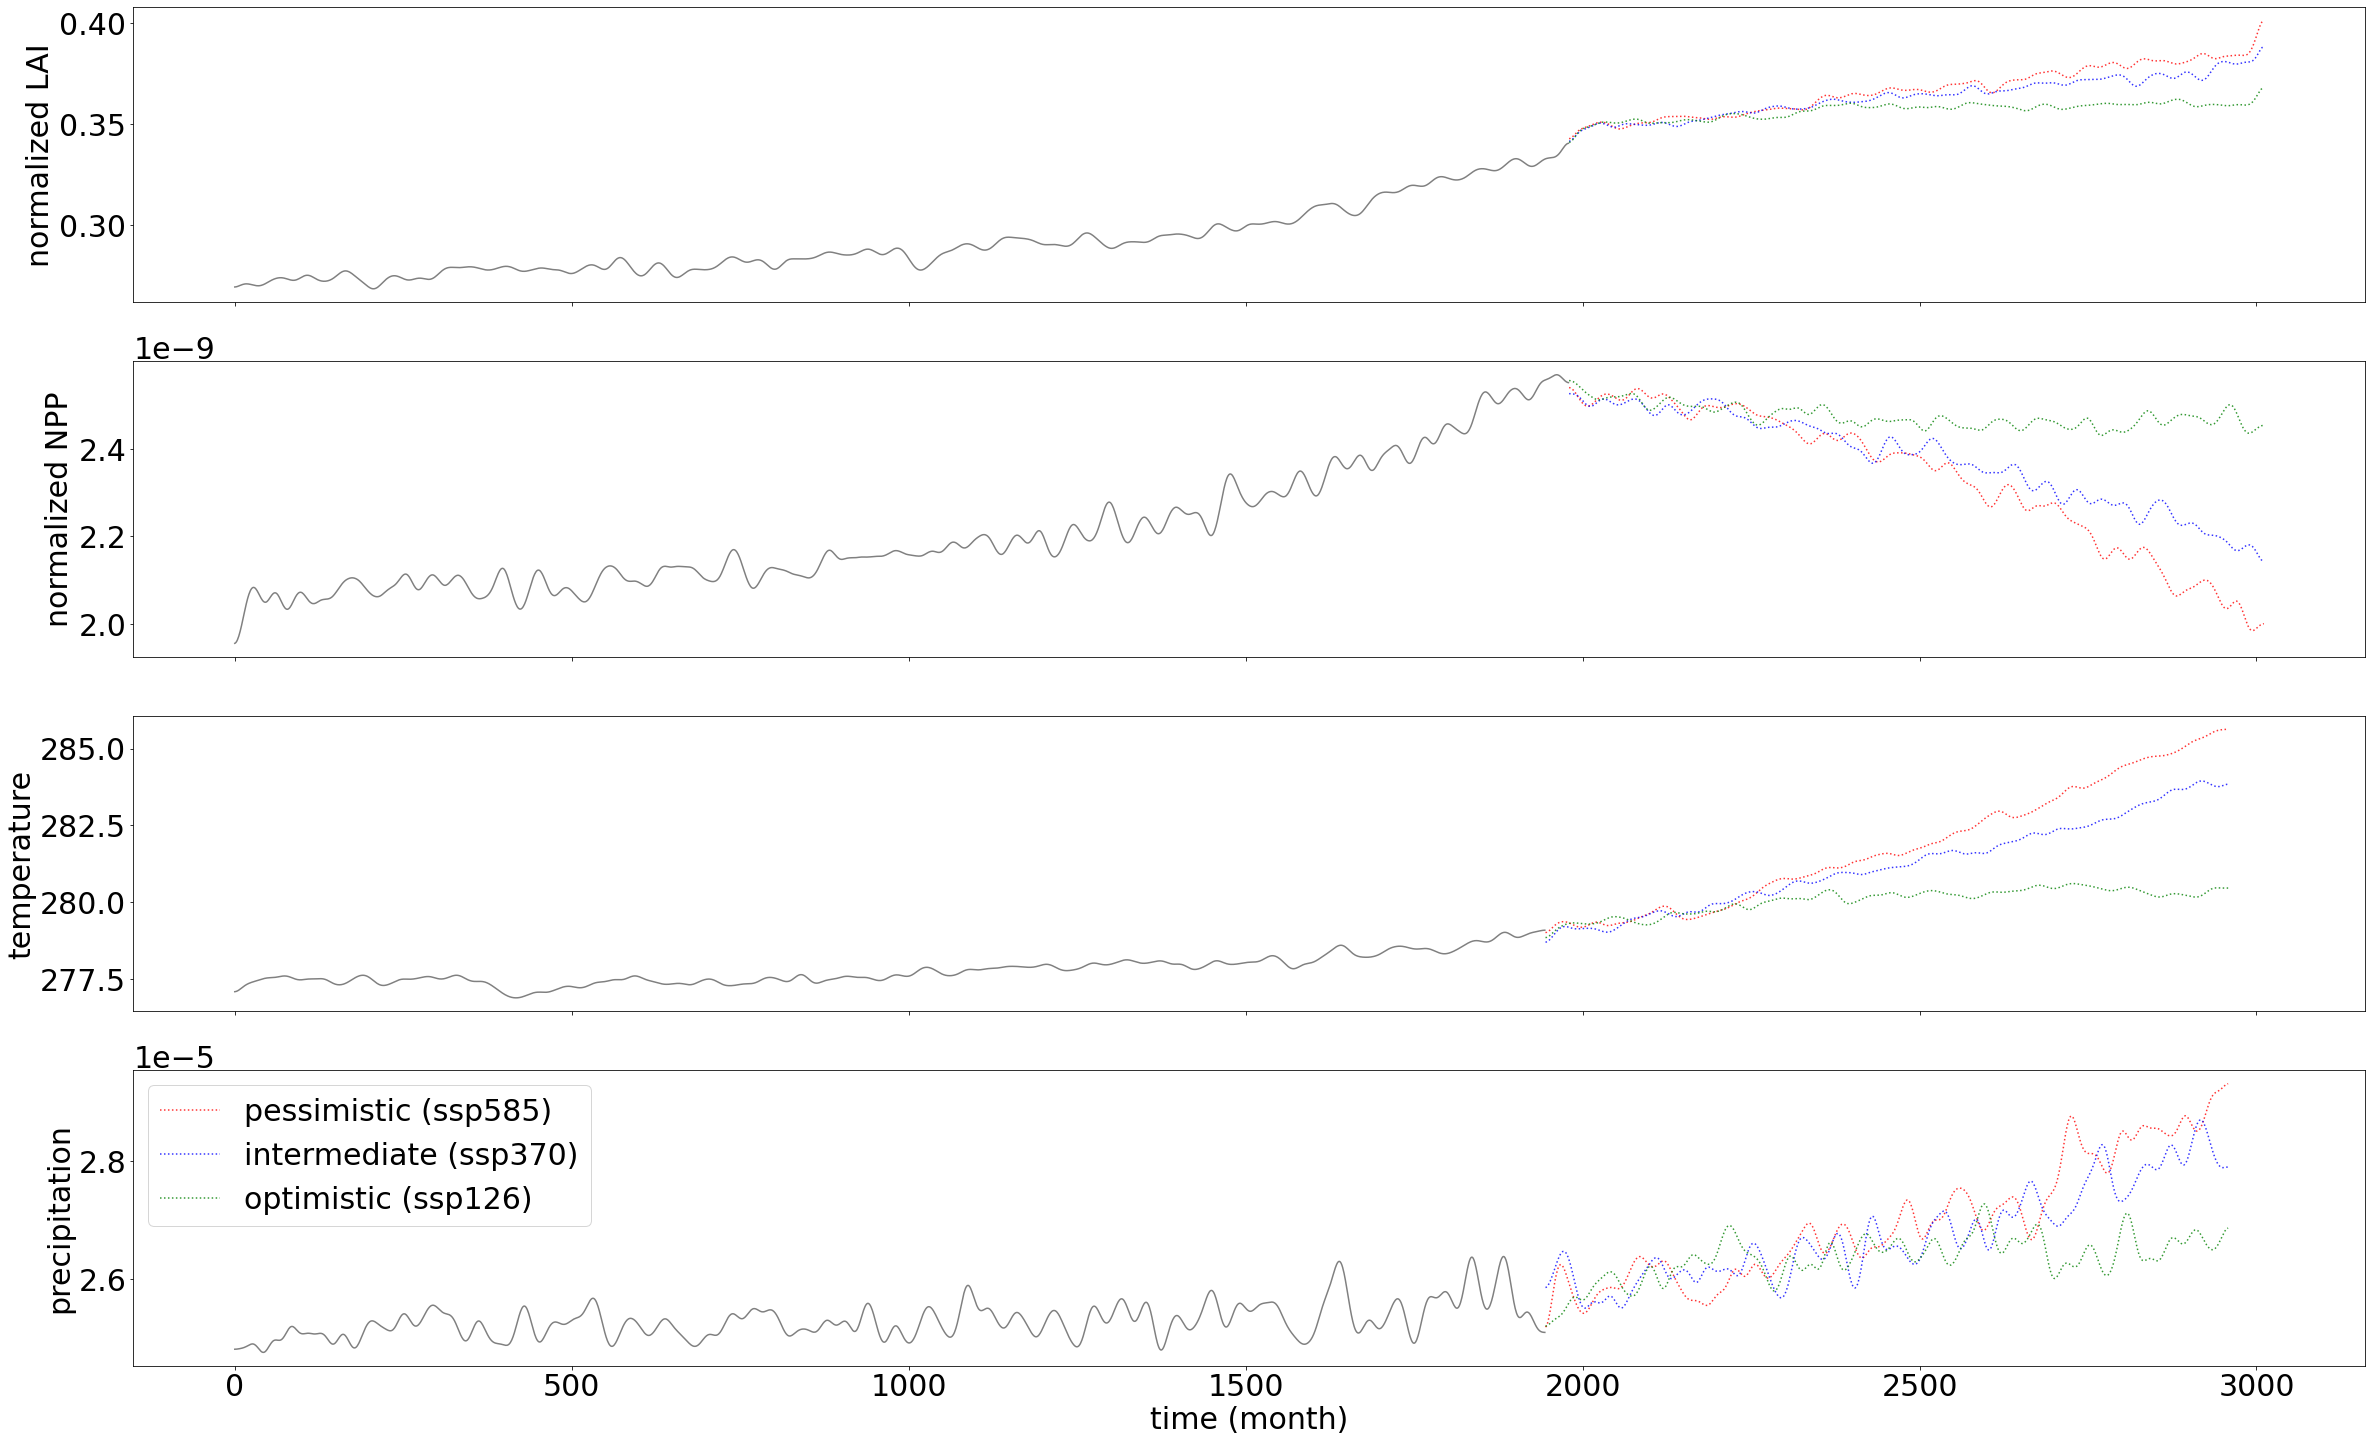

In [68]:
sigma = 10
offset_lai = 0.05
offset_npp = -2.48*1e-8
alpha = 0.8

fig,ax = plt.subplots(4,1, figsize=(40,25), sharex=True)

ax[0].plot(np.arange(dn_lai.shape[0]),
         gaussian_filter1d(dn_lai,sigma),
         color='gray')
ax[0].plot(np.arange(dn_lai.shape[0], dn_lai.shape[0]+lai_future_p.shape[0]), 
         gaussian_filter1d(lai_future_p,sigma) + offset_lai,
         color='red', linestyle='dotted', alpha=alpha, label='pessimistic (ssp585)')
ax[0].plot(np.arange(dn_lai.shape[0], dn_lai.shape[0]+lai_future_p.shape[0]), 
         gaussian_filter1d(lai_future_m,sigma) + offset_lai,
         color='blue', linestyle='dotted', alpha=alpha, label='intermediate (ssp370)')
ax[0].plot(np.arange(dn_lai.shape[0], dn_lai.shape[0]+lai_future_p.shape[0]), 
         gaussian_filter1d(lai_future_o,sigma) + offset_lai,
         color='green', linestyle='dotted', alpha=alpha, label='optimistic (ssp126)')
ax[0].set(ylabel='normalized LAI')

ax[1].plot(np.arange(dn_lai.shape[0]),
         gaussian_filter1d(dn_npp,sigma),
         color='gray')
ax[1].plot(np.arange(dn_lai.shape[0], dn_lai.shape[0]+lai_future_p.shape[0]), 
         gaussian_filter1d(npp_future_p,sigma) + offset_npp,
         color='red', linestyle='dotted', alpha=alpha, label='pessimistic (ssp585)')
ax[1].plot(np.arange(dn_lai.shape[0], dn_lai.shape[0]+lai_future_p.shape[0]), 
         gaussian_filter1d(npp_future_m,sigma) + offset_npp,
         color='blue', linestyle='dotted', alpha=alpha, label='intermediate (ssp370)')
ax[1].plot(np.arange(dn_lai.shape[0], dn_lai.shape[0]+lai_future_p.shape[0]), 
         gaussian_filter1d(npp_future_o,sigma) + offset_npp,
         color='green', linestyle='dotted', alpha=alpha, label='optimistic (ssp126)')
ax[1].set( ylabel='normalized NPP')


ax[2].plot(np.arange(dn_temp.shape[0]),
         gaussian_filter1d(dn_temp,sigma),
         color='gray')
ax[2].plot(np.arange(dn_temp.shape[0], dn_temp.shape[0]+dn_temp_p.shape[0]),
         gaussian_filter1d(dn_temp_p,sigma),
         color='red', linestyle='dotted', alpha=alpha, label='pessimistic (ssp585)')
ax[2].plot(np.arange(dn_temp.shape[0], dn_temp.shape[0]+dn_temp_p.shape[0]),
         gaussian_filter1d(dn_temp_m,sigma),
         color='blue', linestyle='dotted', alpha=alpha, label='intermediate (ssp370)')
ax[2].plot(np.arange(dn_temp.shape[0], dn_temp.shape[0]+dn_temp_p.shape[0]),
         gaussian_filter1d(dn_temp_o,sigma),
         color='green', linestyle='dotted', alpha=alpha, label='optimistic (ssp126)')
ax[2].set(ylabel='temperature')

ax[3].plot(np.arange(dn_temp.shape[0]),
         gaussian_filter1d(dn_prec,sigma),
         color='gray')
ax[3].plot(np.arange(dn_temp.shape[0], dn_temp.shape[0]+dn_temp_p.shape[0]),
         gaussian_filter1d(dn_prec_p,sigma),
         color='red', linestyle='dotted', alpha=alpha, label='pessimistic (ssp585)')
ax[3].plot(np.arange(dn_temp.shape[0], dn_temp.shape[0]+dn_temp_p.shape[0]),
         gaussian_filter1d(dn_prec_m,sigma),
         color='blue', linestyle='dotted', alpha=alpha, label='intermediate (ssp370)')
ax[3].plot(np.arange(dn_temp.shape[0], dn_temp.shape[0]+dn_temp_p.shape[0]),
         gaussian_filter1d(dn_prec_o,sigma),
         color='green', linestyle='dotted', alpha=alpha, label='optimistic (ssp126)')
ax[3].set(xlabel='time (month)', ylabel='precipitation')
ax[3].legend()

fig.savefig('figs/tendency_metrics.eps', bbox_inches='tight')
fig.savefig('figs/tendency_metrics.png', bbox_inches='tight')